# **Analysis of Oxford Weather Data**
***

**Finn McCool July 2019**
***

## **Using Python - Pandas - Matplot and Scipy**
***

**[Link to Met Office data.](https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data)**
***

**Oxford**

Location: 450900E 207200N, Lat 51.761 Lon -1.262, 63 metres amsl**
Estimated data is marked with a * after the value.
Missing data (more than 2 days missing in month) is marked by  ---.
Sunshine data taken from an automatic Kipp & Zonen sensor marked with a #, otherwise sunshine ## data taken from a Campbell Stokes recorder.
***
The co-ordinates are in Woodstock Road,near St. Anne's College. Roughly at garden level.

<img src='img/oxfordMap.png'/>

**[Data courtesy of lat-long-dms](https://www.latlong.net/lat-long-dms.html)**

## **Introduction**
***

I dot accept the masked-man fallacy of the term 'climate change'. A mere 20,000 years ago, I would have been sitting on top of almost a kilometre of ice in relation to where my desk is today. It is therefore an obvious fact that the climate has changed.

It is also a proven fact that there was an extremely cold period lasting more than 500 years from the 1300's until 1850 or so, called the 'Little ice Age'. The 'climate' had radically departed from the 'Medieval Warm' period and, thankfully, has warmed since then.

When today's prophets of doom talk about 'climate change' what they are really referring to is Anthropogenic Global Warming (AGW) caused by a trace gas (CO2).  A trace gas which is essential for life on this planet.

A Mean Global temperature is probably one of the most meaningless numbers bandied about by 'climate' activists such as Extinction Rebellion.

Anyway. To try out the Jupyterlab Version 1, I thought I'd look at the Met Office oldest data set from oxford.

### **The Met Office Data**

I cannot see a way to download the data in _CSV_ format. I copied it from the screen and pasted the data into a text file. I then changed the headers to be more useable.   
It is said that 80% of Data Science is making sure the data is in the right format. This data is no differrent.

It has some problems.

* The data is not comma separated
* The data has a term Provisional for 2019 which does not have a column heading.
* An * is used for estimated data.
* '---' is used for NaN

I had to make a small .sh file to run some **sed** commands. It takes the input file and the output file you want as arguments and cleans up the mess.

I called my file _makecsvargs.sh_. It consists of this:

#!/bin/sh
cat $1 | sed 's/  */,/g' | sed 's/,//' | sed 's/*//g' | sed 's/Provisional//g' | sed 's/---/0/g' > $2

It removes all the sapces and replaces them with a comma. It removes 'Provisional. It removes the asteriks and replaces '---' with Zero (0). Remember. The original file and it's data remain the same.

You can probably do this in Windows, but I would have no idea how!!

Hpefully, I now have a useable copy of the original data. There are some columns about rain and sunshine which I'm not interested in at the moment, but I can drop them easily from the pandas dataframe.

The data itself is almost meaningless. It is Maximum and Minimum teperatures for one month.  
However, it's a nice little data set to learn some Python, Pandas, simple statistics and how to draw some visual conclusions via Matplot.

## **Analysis of Temperature Data for Oxford, UK. 1853 - 2018**
***

>**Import all the necessary modules**

In [111]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
import seaborn as sns

>**Create the Pandas data frame from the CSV file**

>TminC has to be changed to a float using <b>coerce</b>.  I forgot that this column contained some entries marked with an * which was more than likely the problem and led to problems with creating graphs. It is worthwhile to make a copy of the original file and remove these with a simple Linux **sed** command.

In [112]:
oweather = pd.read_csv('OxfordWeather2019copy.csv')

In [113]:
#oweather.dtypes  #Check the data types of the df if if you want
#oweather.head()

In [114]:
oweather['TminC'] = pd.to_numeric(oweather['TminC'],errors='coerce')

>**Variables**

>The variable, **mnth** is used to query for a particular month and <b>tmp</b> represents TmaxC or TminC as an integer, 2 or 3. The variable **dk** is used to hold the year and temperature values. I will iterate over the data frame using the **.iterrows** method and select the temperature for the month based on the values in mnth and tmp and store them in a list
One more variable **tmptxt**, is needed to store a string defining what temperature we are using which will be used mainly for graph titles.

>**Change these variables here to give a different month or temperature to analyse.**

In [115]:
mnth = 12
tmp = 3
dk =[]

for index, row in oweather.iterrows():
    if row[1] == mnth:
        dk.append([row[0],row[tmp]])

if tmp == 2:
    tmptxt = 'Max Temperature'
else:
    tmptxt = 'Min Temperature'

>**Create the new data frame, dfTmp and add some headers.**

In [116]:
dfTmp = pd.DataFrame(dk)
dfTmp.columns = ['Year','Temperature']

>**Get some basic Stats in a variety of ways.**

In [117]:
print('The following values are for the %s recorded in month %i'%(tmptxt,mnth))

The following values are for the Min Temperature recorded in month 12


In [118]:
print(dfTmp['Temperature'].describe())

count    166.000000
mean       2.089157
std        1.934285
min       -4.000000
25%        0.900000
50%        2.200000
75%        3.400000
max        8.300000
Name: Temperature, dtype: float64


In [119]:
print(dfTmp.loc[dfTmp['Temperature'].idxmax()],'\n')     #Maximum Temperature

print(dfTmp.loc[dfTmp['Temperature'].idxmin()])          #Minimum Temperature

Year           2015.0
Temperature       8.3
Name: 162, dtype: float64 

Year           1890.0
Temperature      -4.0
Name: 37, dtype: float64


In [120]:
sigma = dfTmp['Temperature'].std()
print('The Standard Deviation was %3.3f Degrees C'%sigma)

The Standard Deviation was 1.934 Degrees C


In [121]:
mu = dfTmp['Temperature'].mean()
print('The average temperature was %3.2f Degrees C'%mu)

The average temperature was 2.09 Degrees C


>**Graphs**

>First we will create a normal distribution around the observed sample's Average and Standard Deviation using 10k points.
The measurements are from 1853 to 2018 giving 165 data points for each month. 10 bins should be sufficient. (_Sturge's Rule_)
The formula for Probability Density in Python can be found [here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html)
The following code shows a visual representation of a PDF overlaid onto the actual data.
There are easier ways to do this, but it's nice to know the maths.

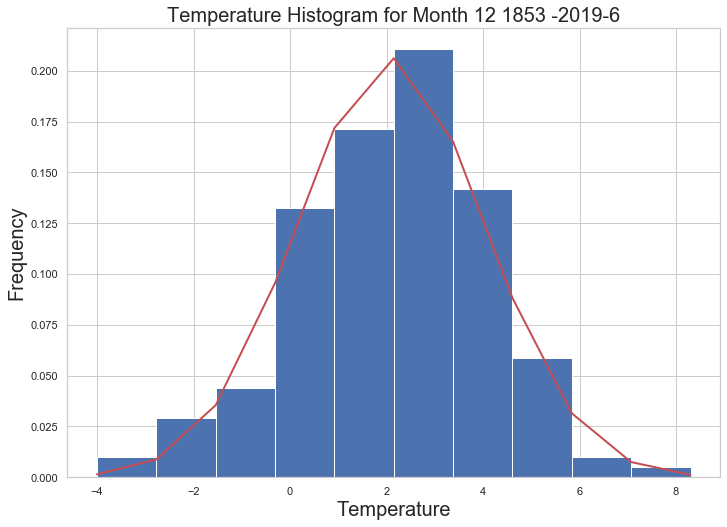

In [158]:
sNormal = np.random.normal(mu, sigma, 100000)
count, bins, ignored = plt.hist(dfTmp['Temperature'],10,density=True)
plt.title('Temperature Histogram for Month %i 1853 -2019-6'%(mnth),fontsize=20)
plt.xlabel('Temperature',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
                np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
          linewidth=2, color='r')
plt.show()

>A seaborn plot is much easier! It does the Kernel Density Estimation for you

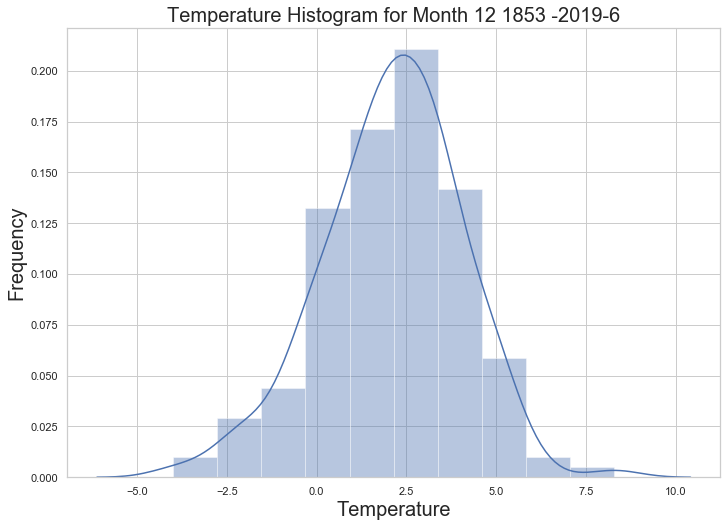

In [159]:
plt.title('Temperature Histogram for Month %i 1853 -2019-6'%(mnth),fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xlabel('Temperature',fontsize=20)
sns.distplot(dfTmp['Temperature'],bins=10);

>The next graph is a basic Pandas scatter plot - Basic

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


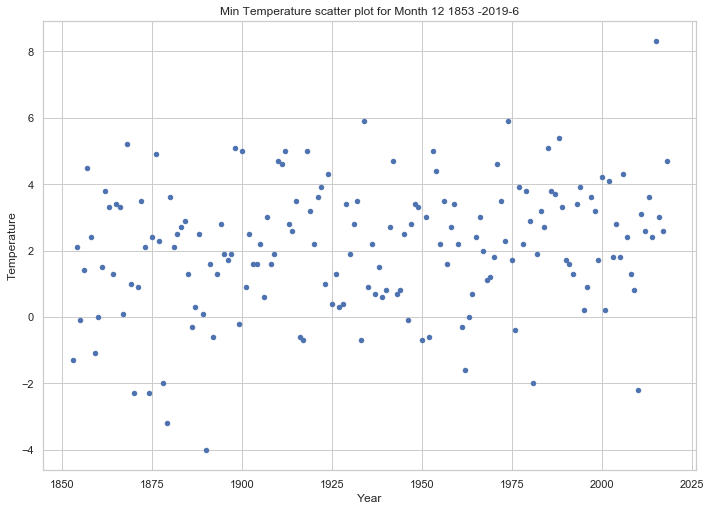

In [160]:
dfTmp.plot.scatter(x='Year',
                   y='Temperature',
                   title=('%s scatter plot for Month %i 1853 -2019-6'%(tmptxt,mnth)),
                   grid=True
                   )
plt.show()

>**Let's try some Seaborn plots...**

>A basic scatter plot with a best fit line.

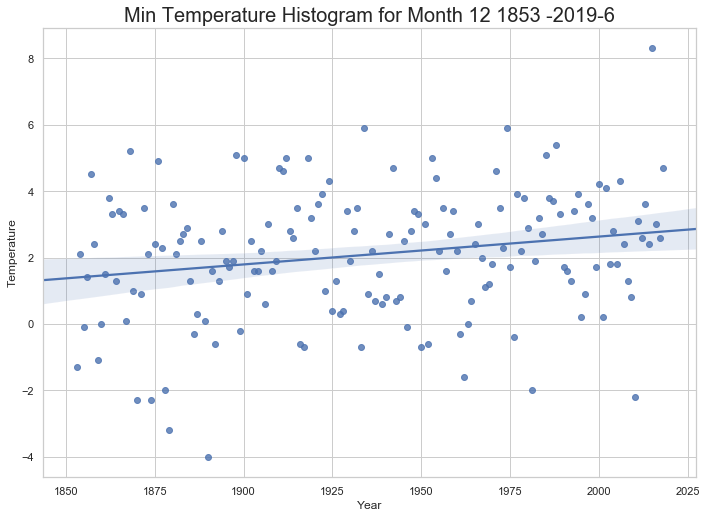

In [161]:
sns.set(context='notebook',style='whitegrid')

sns.regplot(x=dfTmp['Year'], 
            y=dfTmp['Temperature'], 
            fit_reg=True,
           )
plt.title("%s Histogram for Month %i 1853 -2019-6"%(tmptxt,mnth),fontsize=20)
plt.show() 

>A plot of the temperatures showing higher temperatures as bigger points.

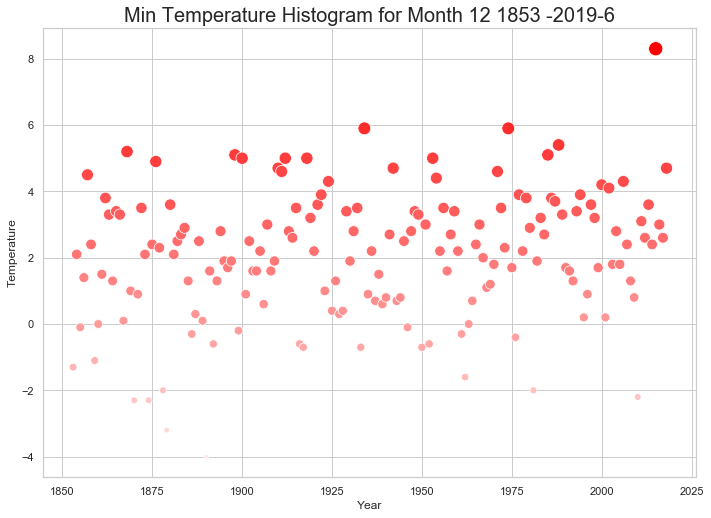

In [162]:
cmap = sns.light_palette("Red", as_cmap=True)

ax = sns.scatterplot(x="Year", y="Temperature",
                      size="Temperature",
                      sizes=(20, 200),
                      palette=cmap,
                      data=dfTmp,
                      hue='Temperature',
                      legend=False
                    )
plt.title('%s Histogram for Month %i 1853 -2019-6'%(tmptxt,mnth),fontsize=20)
plt.show()

>My favourite. A heat map of the temperatures.

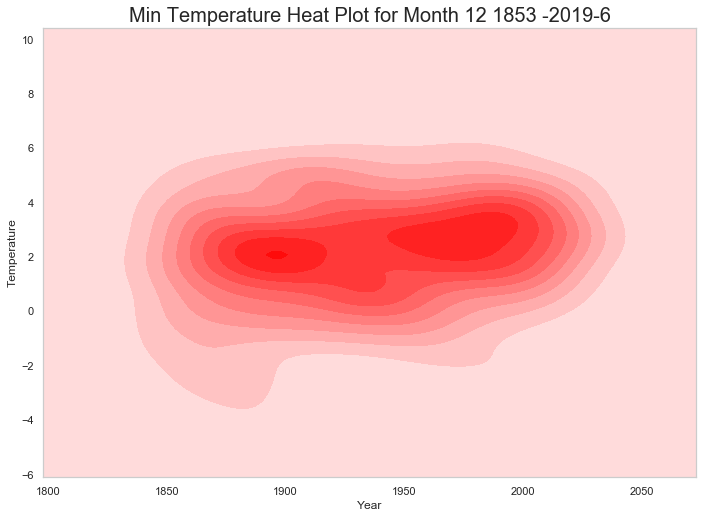

In [163]:
sns.kdeplot(dfTmp['Year'], 
            dfTmp['Temperature'], 
            cmap=cmap, 
            shade=True)
plt.title('%s Heat Plot for Month %i 1853 -2019-6'%(tmptxt,mnth),fontsize=20)
plt.show()

## **Analysis of High/Low temerature difference**

>**Create data points which measure the differential temperature between TmaxC and TminC, but first create a copy of the original data.**

In [128]:
oweatherModified = oweather

tdiff = [ row['TmaxC'] - row['TminC'] for index, row in oweather.iterrows() ]

oweatherModified['TdiffC'] = tdiff

>We still have the variable _mnth_ from our original input and the only temperature we are now interested in is _TavgC_. Let's create a new DF called dfAvg to hold all the data for a particular month and show some basic stats.

In [129]:
dtdiff = []

for index, row in oweather.iterrows():
    if row[1] == mnth:
        dtdiff.append([row[0],row['TdiffC']])
dtdiff = pd.DataFrame(dtdiff)
dtdiff.columns = ['Year','Temperature Difference']

print(dtdiff.loc[dtdiff['Temperature Difference'].idxmax()],'\n') #Maximum temperature

print(dtdiff.loc[dtdiff['Temperature Difference'].idxmin()]) #Minimum Temperature

Year                      1955.0
Temperature Difference       7.2
Name: 102, dtype: float64 

Year                      1927.0
Temperature Difference       3.7
Name: 74, dtype: float64


In [130]:
sigmaDiff = dtdiff['Temperature Difference'].std()

In [131]:
muDiff = dtdiff['Temperature Difference'].mean()

>**Just go through the same code as before, only now with the average temperature.**

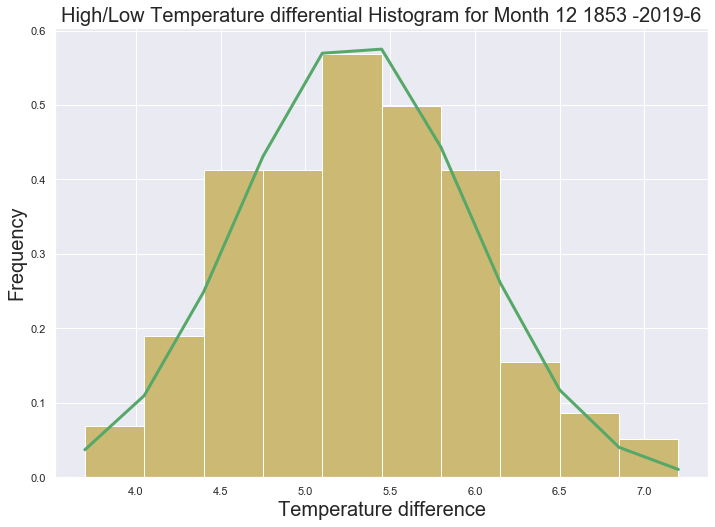

In [143]:
sNormal = np.random.normal(muDiff, sigmaDiff, 100000)
tdiffcount, tdiffbins, ignored = plt.hist(dtdiff['Temperature Difference'],10,density=True,color='y')
plt.title('High/Low Temperature differential Histogram for Month %i 1853 -2019-6'%(mnth),fontsize=20)
plt.xlabel('Temperature difference',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.plot(tdiffbins, 1/(sigmaDiff * np.sqrt(2 * np.pi)) *
                np.exp( - (tdiffbins - muDiff)**2 / (2 * sigmaDiff**2) ),
          linewidth=3, color='g')
plt.show()

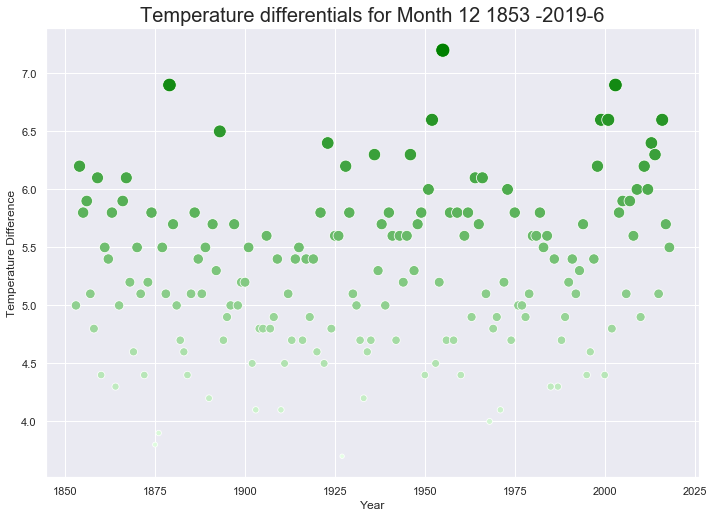

In [142]:
cmapAvg = sns.light_palette("Green", as_cmap=True)
ax = sns.scatterplot(x='Year', y='Temperature Difference',
                      size='Temperature Difference',
                      sizes=(20, 200),
                      palette=cmapAvg,
                      data=dtdiff,
                      hue='Temperature Difference',
                      legend=False
                    )
plt.title('Temperature differentials for Month %i 1853 -2019-6'%(mnth),fontsize=20)
plt.show()

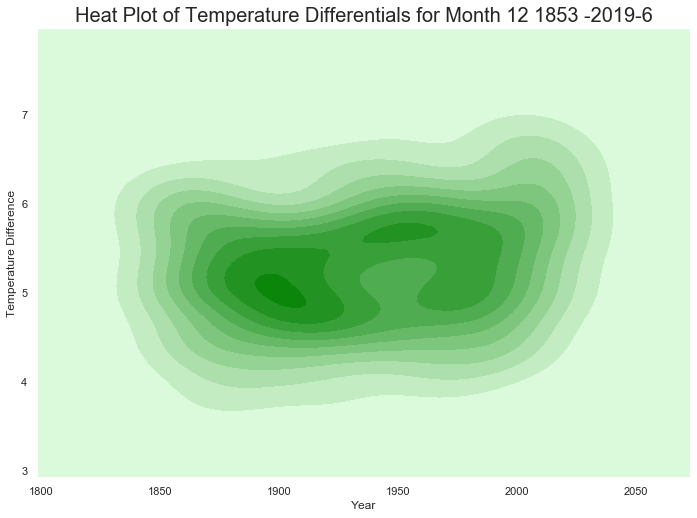

In [140]:
sns.kdeplot(dtdiff['Year'], 
            dtdiff['Temperature Difference'], 
            cmap=cmapAvg, 
            shade=True
           )
plt.title('Heat Plot of Temperature Differentials for Month %i 1853 -2019-6'%(mnth),fontsize=20)
plt.show()

## **December 2015**

One of the data points which caught my eye and why I have left this page on Decber's data, is because 2015 was an unnaturally warm month which I thought needed further investigation. It is such an outlier on the temperature measurements that it needed further looking into.

I collected some data by hand from **[from here](https://www.timeanddate.com/weather/uk/oxford/historic?month=12&year=2015)**
 for the month in question to check the veracity of the data point from the Met Office.

In [135]:
oxford201512 = pd.read_csv('oxfordweather201512.csv')
oxford201512.head(5)

,Tmax,Tmin,Tdiff,Tavg
0,13,9,4,11.0
1,13,13,0,13.0
2,13,12,1,12.5
3,12,11,1,11.5
4,12,11,1,11.5


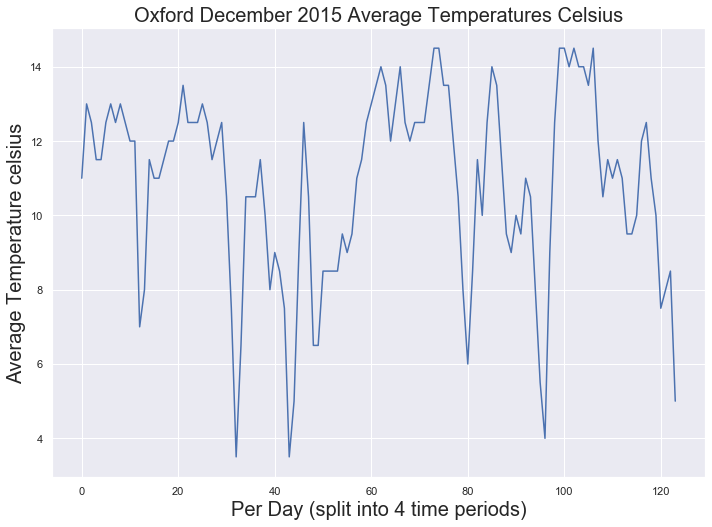

In [139]:
plt.title('Oxford December 2015 Average Temperatures Celsius',fontsize=20)
plt.xlabel('Per Day (split into 4 time periods)',fontsize=20)
plt.ylabel('Average Temperature celsius',fontsize=20)
plt.plot(oxford201512['Tavg']);
plt.show()

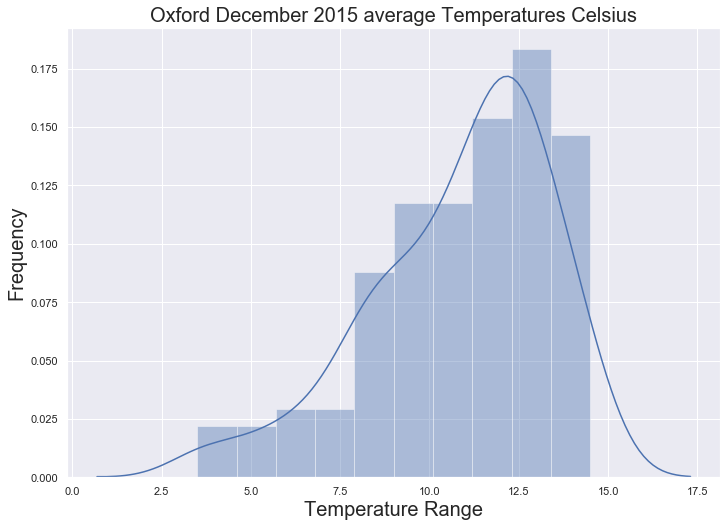

In [138]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(oxford201512['Tavg'],bins=10)
plt.title('Oxford December 2015 average Temperatures Celsius',fontsize=20)
plt.xlabel('Temperature Range',fontsize=20)
plt.ylabel('Frequency',fontsize=20);

>December 2015 was indeed, unnaturally hot!
Of course it was also the month with an extraordinarly strong El Nino according to [**climate.gov**](https://www.climate.gov/news-features/blogs/enso/december-el-ni%C3%B1o-update-phenomenal-cosmic-powers)

## **Conclusion**

This has been an interesting study for me. If you code in any language, it should be to produce something which is useful, interesting and satisfying.  
It is impossible to make any meaningful sense of a list of monthly high and low tempersture data points.  
But. It's a nice data set to start using Python and thanks to the Met for making it available.  
In creating the Jupyter Notebook, I used HTML in preference to Mardown, principally because I wanted to learn how to use it in a simple environmnet. Sadly, exporting a notebook doesn't work well with HTML, so I had to go back to Mardown.

If you want to add the rendered notebook as a Wordpress postthen follow these simple steps:  
  
  1. Sign up for a [github account](https://www.github.com) if you don't already have one.  
  2. Open your save **.ipynb** file in a text editor and copy all the text.  
  3. Create a new Gist (use the little blue icon next to the bell at the top right of the page)  
  4. Give the file a description and a name and paste all the text in.  
  5. Save the file.  
  6. Copy the URL of the gist file and paste it into a paragraph block in Wordpress.

The takeaway's from this little study, apart from refuting bogus claims of climate disaster, are:

* Simple use of Pandas in Python for data analysis
* Some simple statistics
* Using Matplotlib and Seaborn for Drawing Graphs
* How to use Jupyter Lab
* Using HTML to format Jupyter notebooks

Hopefully, it will be of some use to you as you learn Python!  

**It is not an attempt to analyse the causal mechanisms of how the planet's climate changes over millenia.**